In [1]:
import pandas as pd
import numpy as np
import pickle
import calendar
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Data Cleaning

In [14]:

data = pd.read_csv('boulderdaily.csv')

# Replace -998 and -998.0, -999, -999.0 with NaN
data = data.replace(-998, np.nan)
data = data.replace(-998.0, np.nan)
data = data.replace(-999, np.nan)
data = data.replace(-999.0, np.nan)

# Rename mon to month
data = data.rename(columns={'mon': 'month'})

# Combine month, day, year into a single data format column, as first column
data['date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce')
data = data.drop(['year', 'month', 'day'], axis=1)
data = data[['date'] + [col for col in data.columns if col != 'date']]
data = data.dropna(subset=['date'])

# Truncate dataset to start from August 1948
data = data[data['date'] >= '1948-08-01']

# Interpolate missing values based on the date time index
data.set_index('date', inplace=True)
data.interpolate(method='time', inplace=True)
data.reset_index(inplace=True)

# Save the cleaned data
data.to_csv('boulderdaily_cleaned.csv', index=False)
data.head()


/var/folders/fj/b7m96gv142sb26tzg9qm1vw80000gn/T/ipykernel_66478/2147293978.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,date,tmax,tmin,precip,snow,snowcover
0,1948-08-01,89.0,58.0,0.01,0.0,0.0
1,1948-08-02,90.0,56.0,0.01,0.0,0.0
2,1948-08-03,77.0,57.0,0.02,0.0,0.0
3,1948-08-04,67.0,57.0,0.12,0.0,0.0
4,1948-08-05,79.0,57.0,0.04,0.0,0.0


In [15]:
#Check for missing values
data.isnull().sum()

date         0
tmax         0
tmin         0
precip       0
snow         0
snowcover    0
dtype: int64

## Plots

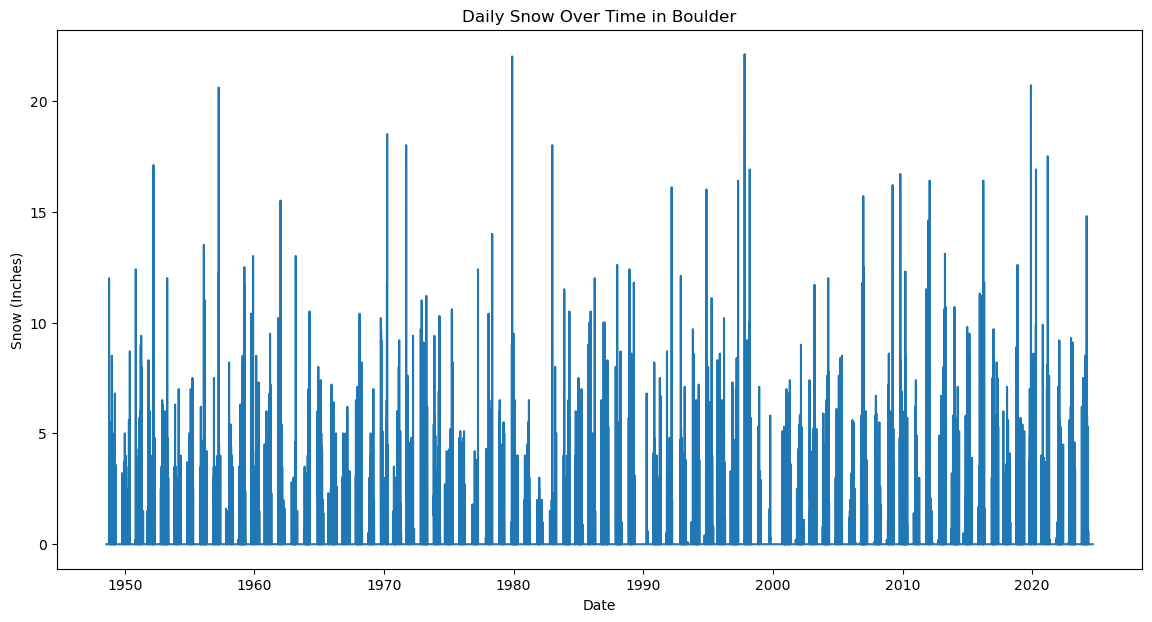

In [4]:
# set plot size to 14" x 7"
plt.rc('figure', figsize = (14, 7))

plt.plot(data['date'], data['snow'], label='Snow')
plt.title('Daily Snow Over Time in Boulder')
plt.xlabel('Date')
plt.ylabel('Snow (Inches)')

plt.show()

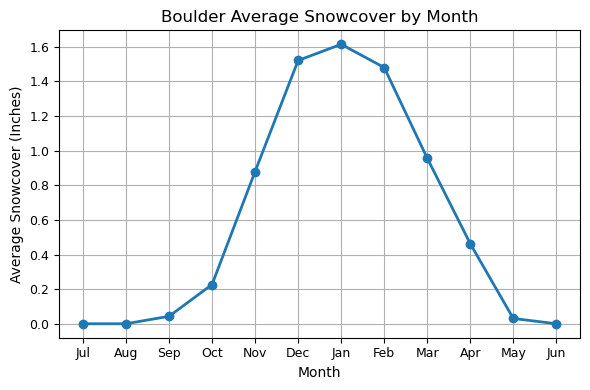

In [5]:
# Create a dictionary to map months starting in July
month_map = {((m - 7) % 12 + 1): calendar.month_abbr[m] for m in range(1, 13)}

# Group by new month order for average snowcover
monthly_snowcover = data.groupby((data['date'].dt.month - 7) % 12 + 1)['snowcover'].mean()

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(monthly_snowcover.index, monthly_snowcover.values, marker='o', markersize=6, linewidth=2)

plt.title('Boulder Average Snowcover by Month', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Average Snowcover (Inches)', fontsize=10)

# Adjusting x-axis to show months starting from July using the dictionary
month_labels = [month_map[m] for m in monthly_snowcover.index]
plt.xticks(monthly_snowcover.index, labels=month_labels, fontsize=9)
plt.yticks(fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

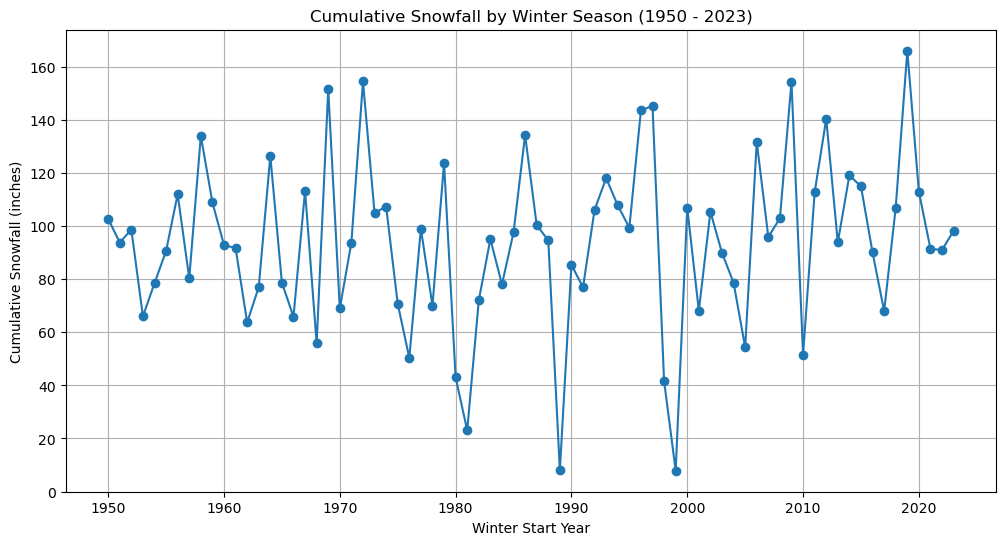

In [6]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Define winter season as starting from September to June of the following year
winter_season_snowfall = []

for start_year in range(1950, 2024):
    winter_season_start = f"{start_year}-09-01"
    winter_season_end = f"{start_year + 1}-05-31"
    
    # Filter the data for just the winter season
    season_data = data[(data['date'] >= winter_season_start) & (data['date'] <= winter_season_end)]
    
    # Cumulative sum
    cumulative_snow = season_data['snow'].sum()
    winter_season_snowfall.append({'winter_start_year': start_year, 'cumulative_snowfall': cumulative_snow})

# Convert to DataFrame
winter_season_df = pd.DataFrame(winter_season_snowfall)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(winter_season_df['winter_start_year'], winter_season_df['cumulative_snowfall'], marker='o')
plt.title("Cumulative Snowfall by Winter Season (1950 - 2023)")
plt.xlabel("Winter Start Year")
plt.ylabel("Cumulative Snowfall (inches)")
plt.grid(True)
plt.show()

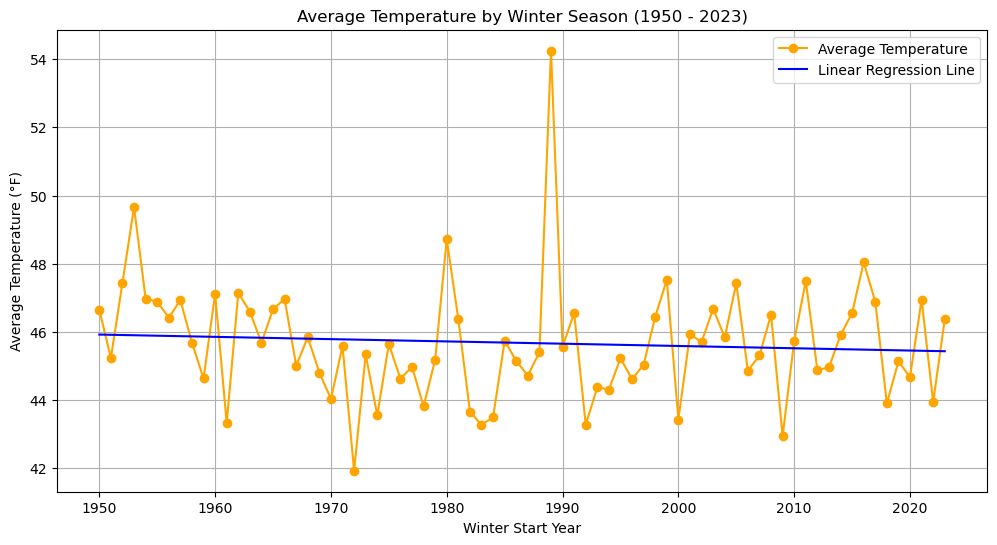

Slope: -0.00001832 degrees/year
R-squared: 0.0068
P-value: 0.4852
Standard Error: 0.0000 degrees/year


In [7]:
# Average temperature for each winter season from 1950 to 2023
winter_season_temp = []

for start_year in range(1950, 2024):
    winter_season_start = f"{start_year}-09-01"
    winter_season_end = f"{start_year + 1}-05-31"
    
    season_data = data[(data['date'] >= winter_season_start) & (data['date'] <= winter_season_end)]
    
    # Average temperature for the season (using the mean of daily average temperatures)
    season_avg_temp = (season_data['tmax'] + season_data['tmin']).mean() / 2
    winter_season_temp.append({'winter_start_year': start_year, 'average_temp': season_avg_temp})

# Convert to DataFrame
winter_season_temp_df = pd.DataFrame(winter_season_temp)

# Convert winter start year to ordinal for regression
winter_season_temp_df['winter_ordinal'] = pd.to_datetime(winter_season_temp_df['winter_start_year'], format='%Y').map(pd.Timestamp.toordinal)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    winter_season_temp_df['winter_ordinal'], winter_season_temp_df['average_temp']
)

# Regression line
regression_line = intercept + slope * winter_season_temp_df['winter_ordinal']

# Plot the average temperature trends over the winter seasons with regression line
plt.figure(figsize=(12, 6))
plt.plot(winter_season_temp_df['winter_start_year'], winter_season_temp_df['average_temp'], marker='o', color='orange', label='Average Temperature')
plt.plot(winter_season_temp_df['winter_start_year'], regression_line, color='blue', label='Linear Regression Line')
plt.title("Average Temperature by Winter Season (1950 - 2023)")
plt.xlabel("Winter Start Year")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.show()

# Print regression statistics
print(f"Slope: {slope:.8f} degrees/year")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Standard Error: {std_err:.4f} degrees/year")


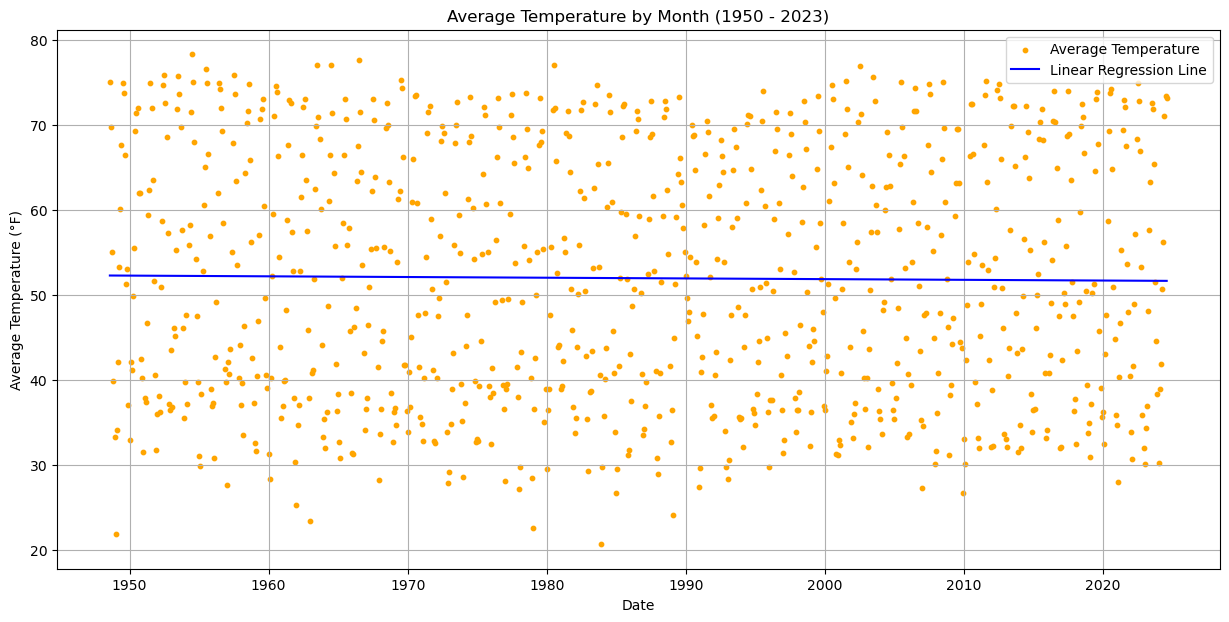

Slope: -0.00002263 days/year
R-squared: 0.0002
P-value: 0.7052
Standard Error: 0.0001 days/year


In [8]:
# Copy dataframe
data_wtih_avg = data.copy()

# Calculate the average temperature for each day
data_wtih_avg['average_temp'] = (data_wtih_avg['tmax'] + data_wtih_avg['tmin']) / 2

# Create explicit 'year' and 'month' columns
data_wtih_avg['year'] = data_wtih_avg['date'].dt.year
data_wtih_avg['month'] = data_wtih_avg['date'].dt.month

# Create 'month_start' as the first day of each month
data_wtih_avg['month_start'] = data_wtih_avg['date'].dt.to_period('M').dt.to_timestamp()

# Get the average temperature for each month
monthly_avg_temp = data_wtih_avg.groupby('month_start')['average_temp'].mean().reset_index()

# Remove outliers using IQR
Q1 = monthly_avg_temp['average_temp'].quantile(0.25)
Q3 = monthly_avg_temp['average_temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_monthly_avg_temp = monthly_avg_temp[
    (monthly_avg_temp['average_temp'] >= lower_bound) &
    (monthly_avg_temp['average_temp'] <= upper_bound)
]


# Linear regression on the filtered data
filtered_monthly_avg_temp['month_ordinal'] = filtered_monthly_avg_temp['month_start'].map(pd.Timestamp.toordinal)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_monthly_avg_temp['month_ordinal'], filtered_monthly_avg_temp['average_temp']
)

regression_line = intercept + slope * filtered_monthly_avg_temp['month_ordinal']

# Plot the average temperature trends over the months
plt.figure(figsize=(15, 7))
plt.scatter(filtered_monthly_avg_temp['month_start'], filtered_monthly_avg_temp['average_temp'], color='orange', label='Average Temperature', s=10)
plt.plot(filtered_monthly_avg_temp['month_start'], regression_line, color='blue', label='Linear Regression Line')
plt.title("Average Temperature by Month (1950 - 2023)")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.legend()
plt.show()

print(f"Slope: {slope:.8f} days/year")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Standard Error: {std_err:.4f} days/year")


P-value is very very high, so we can't reject the null hypothesis. With standard error so high the true slope could be positive, the linear regression line is not reliable at all.

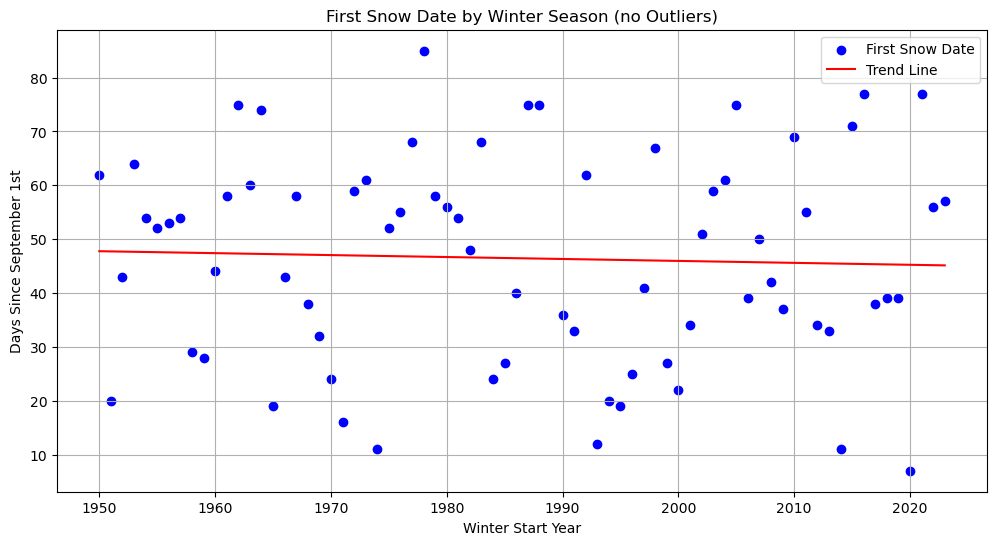

Slope: -0.0360 days/year
Intercept: 118.03 days
R-squared: 0.0016
P-value: 0.7339
Standard Error: 0.1056 days/year


In [9]:
# Define inches for "first snow" threshold
first_snow_threshold = 0.1 #inch

# List to store the first snow date for each winter season
first_snow_dates = []

for start_year in range(1950, 2024):
    winter_start = pd.Timestamp(f'{start_year}-09-01')
    winter_end = pd.Timestamp(f'{start_year + 1}-05-31')

    # Filter data for just the winter season
    winter_data = data[(data['date'] >= winter_start) & (data['date'] <= winter_end)]

    # Get days with snow greater than the threshold
    snow_days = winter_data[winter_data['snow'] >= first_snow_threshold]# | (winter_data['snow'] > first_snow_threshold)]

    # if start_year == 2010:
    #     print(snow_days)

    first_snow_date = snow_days['date'].min()
    first_snow_dates.append({
        'winter_start_year': start_year,
        'first_snow_date': first_snow_date
    })
    

# Convert to DataFrame
first_snow_df = pd.DataFrame(first_snow_dates)

# Drop seasons without a first snow date
first_snow_df = first_snow_df.dropna(subset=['first_snow_date'])

# Calculate the number of days since September 1st for each first snow date
first_snow_df['days_since_sept1'] = (
    first_snow_df['first_snow_date'] -
    pd.to_datetime(first_snow_df['winter_start_year'].astype(str) + '-09-01')
).dt.days

# Remove outliers using the IQR method
Q1 = first_snow_df['days_since_sept1'].quantile(0.25)
Q3 = first_snow_df['days_since_sept1'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_snow_df = first_snow_df[
    (first_snow_df['days_since_sept1'] >= lower_bound) &
    (first_snow_df['days_since_sept1'] <= upper_bound)
]

# Plot the first snow dates over the years without outliers
plt.figure(figsize=(12, 6))
plt.scatter(
    filtered_snow_df['winter_start_year'],
    filtered_snow_df['days_since_sept1'],
    color='blue',
    label='First Snow Date'
)
plt.title("First Snow Date by Winter Season (no Outliers)")
plt.xlabel("Winter Start Year")
plt.ylabel("Days Since September 1st")
plt.grid(True)

# Perform linear regression on the filtered data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    filtered_snow_df['winter_start_year'],
    filtered_snow_df['days_since_sept1']
)

# Create regression line values
regression_line = intercept + slope * filtered_snow_df['winter_start_year']

# Plot the regression line
plt.plot(
    filtered_snow_df['winter_start_year'],
    regression_line,
    color='red',
    label='Trend Line'
)

plt.legend()
plt.show()

# Optionally, print regression statistics
print(f"Slope: {slope:.4f} days/year")
print(f"Intercept: {intercept:.2f} days")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Standard Error: {std_err:.4f} days/year")


P-value is very very high, so we can't reject the null hypothesis. With standard error so high the true slope could be positive, the linear regression line is not reliable at all.

In [10]:
# Code used from XCast documentation examples
from sklearn.model_selection import TimeSeriesSplit
import xcast as xc
from xcast.verification import (
    index_of_agreement,
    kling_gupta_efficiency,
    normalized_centered_root_mean_squared_error,
)

# Ensure 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Create lag features
data['snowcover_yesterday'] = data['snowcover'].shift(1)
data['snow_yesterday'] = data['snow'].shift(1)

# Drop NaN values resulting from lag features
data.dropna(subset=['snowcover_yesterday', 'snow_yesterday'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Set train / test
winter_2023_start = '2023-09-01'
winter_2023_end = '2024-05-31'
train_data = data[data['date'] < winter_2023_start].copy()
test_data = data[(data['date'] >= winter_2023_start) & (data['date'] <= winter_2023_end)].copy()

# x is the input features (predictors), y is the target
x_train = train_data[['tmax', 'tmin', 'precip', 'snowcover_yesterday', 'snow_yesterday']].values
y_train = train_data['snow'].values.reshape(-1, 1)
x_test = test_data[['tmax', 'tmin', 'precip', 'snowcover_yesterday', 'snow_yesterday']].values
y_test = test_data['snow'].values.reshape(-1, 1)

In [11]:
# Define ELM parameters
elm_kwargs = {
  'regularization': 10,
  'hidden_layer_size': 10,#5
  'activation': 'relu',#, 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
  'preprocessing':'minmax',# 'preprocessing': ['minmax', 'std', 'none' ],
  #'encoding': 'nonexceedance',#'encoding': [  'nonexceedance', 'binary'],
  #'quantiles': [1/3,2/3], #[0.0001, 0.5, 0.9999], [0.2, 0.4, 0.6, 0.8], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] ],
  #'standardize_y': True,#'standardize_y': [True, False],
  'n_estimators': 100,#30
  #'initialization':'normal'# ['uniform', 'normal', 'xavier']
}

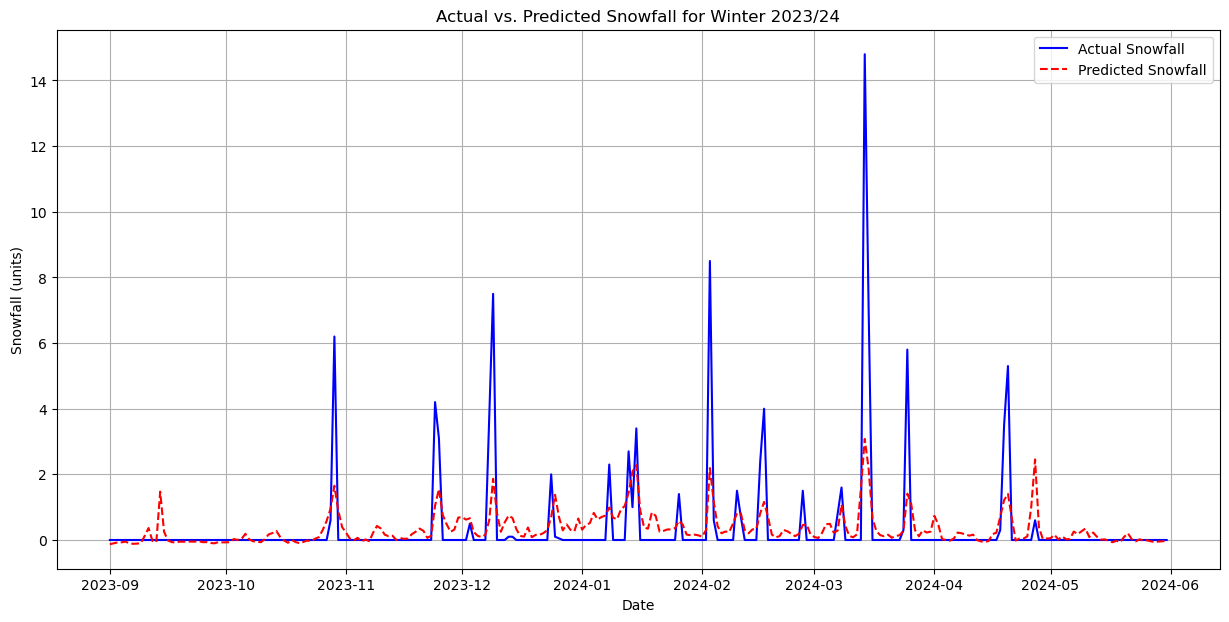

ELM Evaluation for Winter 2023/24:
CC: 0.7030
IOA: 0.6027
KGE: 0.0596
NCRMSE: 3.2487


In [12]:
# Train the ELM model
elm = xc.extreme_learning_machine(**elm_kwargs)
elm.fit(x_train, y_train)

# Predict snowfall on test data (Winter 2023/24)
predictions = elm.predict(x_test)

# Prepare the results for plotting
results_df = test_data[['date']].copy()
results_df['Actual Snowfall'] = y_test
results_df['Predicted Snowfall'] = predictions

# Plot the actual vs. predicted snowfall
plt.figure(figsize=(15, 7))
plt.plot(results_df['date'], results_df['Actual Snowfall'], label='Actual Snowfall', color='blue')
plt.plot(results_df['date'], results_df['Predicted Snowfall'], label='Predicted Snowfall', color='red', linestyle='--')
plt.title('Actual vs. Predicted Snowfall for Winter 2023/24')
plt.xlabel('Date')
plt.ylabel('Snowfall (units)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model performance on Winter 2023/24
cc_test = stats.pearsonr(predictions.squeeze(), y_test.squeeze())[0]
ioa_test = index_of_agreement(predictions, y_test)
kge_test = kling_gupta_efficiency(predictions, y_test)
ncrmse_test = normalized_centered_root_mean_squared_error(predictions, y_test)
print('ELM Evaluation for Winter 2023/24:')
print(f'CC: {cc_test:.4f}')
print(f'IOA: {ioa_test:.4f}')
print(f'KGE: {kge_test:.4f}')
print(f'NCRMSE: {ncrmse_test:.4f}')


In [13]:
# Time series Cross-Validation on the training data
time_series_cv = TimeSeriesSplit(n_splits=24)

xval_preds, xval_y = [], []

for train_idx, val_idx in time_series_cv.split(x_train):
    xtrain_cv, ytrain_cv = x_train[train_idx], y_train[train_idx]
    xval_cv, yval_cv = x_train[val_idx], y_train[val_idx]
    
    xval_y.append(yval_cv)
    
    # Initialize and train the ELM model
    elm_cv = xc.extreme_learning_machine(**elm_kwargs)
    elm_cv.fit(xtrain_cv, ytrain_cv)
    
    # Predict on validation set
    preds_cv = elm_cv.predict(xval_cv)
    xval_preds.append(preds_cv)

# Concatenate predictions and true values from cross-validation
preds_cv = np.vstack(xval_preds)
true_values_cv = np.vstack(xval_y)

# Evaluate cross-validation performance
cc_cv = stats.pearsonr(preds_cv.squeeze(), true_values_cv.squeeze())[0]
ioa_cv = index_of_agreement(preds_cv, true_values_cv)
kge_cv = kling_gupta_efficiency(preds_cv, true_values_cv)
ncrmse_cv = normalized_centered_root_mean_squared_error(preds_cv, true_values_cv)

print('ELM Cross-Validation Evaluation on Training Data:')
print(f'CC: {cc_cv:.4f}')
print(f'IOA: {ioa_cv:.4f}')
print(f'KGE: {kge_cv:.4f}')
print(f'NCRMSE: {ncrmse_cv:.4f}')
print('---')

ELM Cross-Validation Evaluation on Training Data:
CC: 0.6020
IOA: 0.6002
KGE: 0.0694
NCRMSE: 3.7454
---
